In [1]:
# %matplotlib widget
%matplotlib inline

In [2]:
import datetime as dt
from datetime import datetime
from pathlib import Path
from typing import Sequence, Tuple, List

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"   # 0 = all, 1 = INFO, 2 = WARNING, 3 = ERROR
import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)

import pickle
import contextlib

import platform 
import sys
import math

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view
import pandas as pd
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, metrics, mixed_precision, regularizers
from tensorflow.keras.mixed_precision import LossScaleOptimizer
from tensorflow.keras.optimizers.schedules import CosineDecayRestarts, LearningRateSchedule
import torch

import matplotlib
import matplotlib.pyplot as plt         # ← for progress curves
from IPython.display import display, update_display, clear_output

from tqdm.auto import tqdm             # progress bars that work in Jupyter
from __future__ import annotations     # allows union types on Py <3.10

import importlib
import stockanalibs
importlib.reload(stockanalibs)


2025-06-26 20:37:42.452029: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750963062.587770    5914 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750963062.629584    5914 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750963062.962076    5914 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750963062.962137    5914 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750963062.962140    5914 computation_placer.cc:177] computation placer alr

<module 'stockanalibs' from '/mnt/g/My Drive/Ingegneria/Data Science GD/My-Practice/my models/Trading/0.Stock Analysis/stockanalibs.py'>

In [3]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "" # to deactivate gpu
# tf.config.set_visible_devices([], 'GPU') # to deactivate gpu

print("Python :", platform.python_version(), "\n")
print("TF GPUs :", tf.config.list_physical_devices('GPU'))
print("Torch   :", torch.__version__, "CUDA-OK:", torch.cuda.is_available())


Python : 3.10.18 

TF GPUs : [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Torch   : 2.2.2+cu121 CUDA-OK: True


In [4]:
ticker = stockanalibs.ticker

df = pd.read_csv(f"dfs training/{ticker}_final.csv", index_col=0, parse_dates=True)
df

,open,high,low,close,volume,bid,ask,trade_action,StrategyEarning,EarningDiff,signal_smooth_adjusted
2014-04-03 13:33:00,28.5959,28.5959,28.5932,28.5932,5540.0,28.5846,28.6018,0,0.000,0.000,0.625132
2014-04-03 13:34:00,28.5809,28.5809,28.5809,28.5809,5084.0,28.5724,28.5895,0,0.000,0.000,0.649119
2014-04-03 13:35:00,28.5809,28.5809,28.5809,28.5809,5084.0,28.5724,28.5895,0,0.000,0.000,0.670647
2014-04-03 13:36:00,28.5809,28.5809,28.5809,28.5809,5084.0,28.5724,28.5895,0,0.000,0.000,0.689432
2014-04-03 13:37:00,28.5809,28.5809,28.5809,28.5809,5084.0,28.5724,28.5895,0,0.000,0.000,0.706628
...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,173.3750,173.6771,173.2150,173.5650,621199.0,173.5129,173.6171,0,-0.379,2.331,0.000000
2025-06-18 20:57:00,173.5650,173.5900,173.2400,173.3800,624198.0,173.3280,173.4320,0,-0.379,2.516,0.000000
2025-06-18 20:58:00,173.3900,173.4100,173.2000,173.3100,454542.0,173.2580,173.3620,0,-0.379,2.586,0.000000
2025-06-18 20:59:00,173.3150,173.4000,173.2300,173.2800,1094746.0,173.2280,173.3320,0,-0.379,2.616,0.000000


In [5]:
###############################################################################
# 0 ·  DATA & PATHS                                                           #
###############################################################################
label_col      = stockanalibs.label_col
feature_cols   = stockanalibs.feature_cols

LOOK_BACK      = stockanalibs.look_back                                
N_FEATS        = len(feature_cols) * LOOK_BACK     # final feature length

today          = datetime.now().strftime("%Y-%m-%d")

rth_start      = stockanalibs.regular_start

save_dir       = Path("dfs training")
weights_path   = save_dir / f"{ticker}_{today}.weights.h5"   # auto-per‐ticker
model_path     = save_dir / f"{ticker}_{today}_model.keras"

# dataset split proportions
TRAIN_PROP, VAL_PROP = 0.70, 0.15                 # → 0.15 test remainder

In [6]:
###############################################################################
# 1 · MODEL HYPER-PARAMETERS (tuned defaults)
###############################################################################

# ── Architecture Parameters ───────────────────────────────────────────────
SHORT_UNITS         = 48       # LSTM short-term units (32–128 recommended)
LONG_UNITS          = 128      # LSTM long-term units (64–256 recommended)
DROPOUT_SHORT       = 0.30     # Dropout for short LSTM outputs (0.1–0.3)
DROPOUT_LONG        = 0.25     # Dropout for long LSTM outputs (0.1–0.3)
REC_DROP_SHORT      = 0.0      # Must be 0 for fused LSTM kernels
REC_DROP_LONG       = 0.0      # Must be 0 for fused LSTM kernels
KERNEL_REG          = 1e-3     # L2 regularization factor for LSTM layers

# ── Optimizer Settings: Cosine Decay with Restarts ──────────────────────────
INITIAL_LR          = 5e-4     # Initial learning rate (1e-4 to 1e-3)
FIRST_DECAY_EPOCHS  = 5        # Epochs before first decay
T_MUL               = 2.0      # Cycle length multiplier
M_MUL               = 1.0      # Cycle LR scaling factor after restarts
ALPHA               = 0.03     # Minimum LR factor relative to INITIAL_LR
LOSS_FN             = "mse"    # Loss (MSE for regression)
CLIPNORM            = 1.0      # Gradient clipping norm (0.5–5.0)

# ── Training Control Parameters ─────────────────────────────────────────────
TRAIN_BATCH         = 32       # Training batch size (32–128)
VAL_BATCH           = 1        # Validation batch size (usually 1)
MAX_EPOCHS          = 120       # Max training epochs (50–150)
EARLY_STOP_PATIENCE = 12       # Early stopping patience (10–20 epochs)
USE_FP16            = True     # Enable FP16 for faster training and lower memory use


In [7]:
def build_lstm_tensors(
    df: pd.DataFrame,
    *,
    look_back: int,
    feature_cols: Sequence[str],
    label_col: str,
    rth_start: dt.time
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """
    Converts one big minute-bar DataFrame (many days) into NumPy arrays ready for the stateful LSTM.
    
    RULES ENFORCED:
      • Windows never cross midnight.
      • Features and labels are standardized per day (to avoid leakage).
    
    Returns:
      X         : Design matrix; every row is a sliding window (flattened).
      y         : One-step-ahead targets corresponding to each window.
      raw_close : Raw (unstandardized) close prices for each target.
      raw_bid   : Raw bid prices.
      raw_ask   : Raw ask prices.
    """
    X_rows, y_rows, close_rows, bid_rows, ask_rows = [], [], [], [], []
    
    # Process one calendar day at a time.
    for date, day_df in df.groupby(df.index.normalize()):
        day_df = day_df.sort_index()
        
        # Extract raw price columns before scaling.
        raw_close = day_df["close"].to_numpy(dtype=np.float32)
        raw_bid   = day_df["bid"].to_numpy(dtype=np.float32)
        raw_ask   = day_df["ask"].to_numpy(dtype=np.float32)
        
        # Standardize features and target per day.
        day_df[feature_cols] = StandardScaler().fit_transform(day_df[feature_cols]) ####################################################################
        # day_df[label_col] = StandardScaler().fit_transform(day_df[[label_col]]) ###################################################################
        
        feats_np = day_df[feature_cols].to_numpy(dtype=np.float32)  # shape: (T, n_feats)
        label_np = day_df[label_col].to_numpy(dtype=np.float32)       # shape: (T,)
        
        # Create mask for Regular Trading Hours (RTH).
        rth_mask = day_df.index.time >= rth_start
        if not rth_mask.any():
            continue
        
        T, _ = feats_np.shape
        
        # Build sliding windows using vectorized approach.
        win_3d = sliding_window_view(feats_np, (look_back, feats_np.shape[1]), axis=(0, 1))
        # After the sliding window operation, we get an array whose shape is roughly (T - look_back + 1, 1, look_back, n_feats).
        win_3d = win_3d[:, 0, :, :]  # removes the extra dimension: (T - look_back + 1, look_back, n_feats)
        
        # Alignment fix: drop the last window so that targets align.
        win_3d = win_3d[:-1] # drops the very last window. This makes the number of windows exactly equal to the number of available targets.
        y_aligned = label_np[look_back:]              # (T - look_back,)
        close_aligned = raw_close[look_back:]    # (T - look_back,)
        bid_aligned   = raw_bid[look_back:]      # (T - look_back,)
        ask_aligned   = raw_ask[look_back:]      # (T - look_back,)
        
        # Trim by RTH (apply mask to the target indices).
        rth_mask_shifted = rth_mask[look_back:]
        win_3d       = win_3d[rth_mask_shifted]
        y_aligned    = y_aligned[rth_mask_shifted]
        close_aligned = close_aligned[rth_mask_shifted]
        bid_aligned   = bid_aligned[rth_mask_shifted]
        ask_aligned   = ask_aligned[rth_mask_shifted]
        
        # Flatten each window
        X_rows.append(win_3d.reshape(win_3d.shape[0], -1))
        y_rows.append(y_aligned)
        close_rows.append(close_aligned)
        bid_rows.append(bid_aligned)
        ask_rows.append(ask_aligned)
    
    if not X_rows:
        raise ValueError("No valid RTH windows found; check rth_start or data gaps.")
    
    X = np.concatenate(X_rows).astype(np.float32)
    y = np.concatenate(y_rows).astype(np.float32)
    raw_close = np.concatenate(close_rows).astype(np.float32)
    raw_bid   = np.concatenate(bid_rows).astype(np.float32)
    raw_ask   = np.concatenate(ask_rows).astype(np.float32)
    
    return X, y, raw_close, raw_bid, raw_ask


In [8]:
X, y, raw_close, raw_bid, raw_ask = build_lstm_tensors(
    df=df,
    look_back=LOOK_BACK,
    feature_cols=feature_cols,
    label_col=label_col,
    rth_start=rth_start
)

print(X.shape) # we use 'm' features and 'n' previous look back values to predict each 1 label
print(y.shape) # 'n' lookback values * 'n_days_df' (all pretrade values) are deducted from the original df shape

(1066222, 300)
(1066222,)


In [9]:
def chronological_split(
    X: np.ndarray,
    y: np.ndarray,
    raw_close: np.ndarray,
    raw_bid: np.ndarray,
    raw_ask: np.ndarray,
    df: pd.DataFrame,           # same DataFrame used to build X, y
    *,
    look_back: int,
    rth_start: dt.time,
    train_prop: float,
    val_prop: float,
    TRAIN_BATCH: int  # added parameter for training batch size
) -> Tuple[
        Tuple[np.ndarray, np.ndarray],    # (X_train, y_train)
        Tuple[np.ndarray, np.ndarray],    # (X_val, y_val)
        Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray],    # (X_test, y_test, raw_close_test, raw_bid_test, raw_ask_test)
        List[int],                        # samples_per_day
        np.ndarray, np.ndarray, np.ndarray  # day_id_tr, day_id_val, day_id_te
    ]:
    """
    Splits X, y (and the raw signals) into chronological train/val/test partitions by whole days.
    The code creates a day-based vector (day_id_vec) and then applies masks to split all windows into training, validation, and test groups. 
    Each group is consecutive in terms of days, so no day is dropped or skipped—the splits follow in order. 
    This ensures that if we later recombine the splits, they cover all days from 0 to D–1.

            [ Training ]         [ Validation ]            [ Test ]
    Days: 0   ...   cut_train | cut_train+1 ... cut_val | cut_val+1 ... D-1
    
    It uses the following logic:
      1. Count the number of usable windows per calendar day.
      2. Create a day_id vector that tags each sample with its day.
      3. Compute the total number of calendar days, D.
      4. Compute the "original" intended training set size as D * train_prop.
      5. Round this count up (in day units) to the next multiple of TRAIN_BATCH.
         (This ensures that the training set always contains full training batches.)
      6. The validation split starts immediately after training ends. 
      7. The test split then follows, with no data dropped.
    
    Returns:
      ((X_tr, y_tr), (X_val, y_val), (X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te),
       samples_per_day, day_id_tr, day_id_val, day_id_te)
       
    samples_per_day : list[int]
        Number of usable windows contributed by each calendar day.
        +-----------------------------------------------------------+
        |  Total minute rows (T)                                    |
        |                                                           |
        |   0, 1, 2, ... , look_back-1  | look_back, ..., T-1         |
        |      (Not ready)            |  (Potential windows)         |
        |                              |   ┌──────────┐               |
        |                              |   │ rth_start│ <-- Only count rows with timestamp >= rth_start
        |                              |   └──────────┘               |
        |                              |    Usable windows = count of rows satisfying both conditions
        +-----------------------------------------------------------+

    day_id_tr / day_id_val / day_id_te : np.ndarray
        For every sample in each split, which day (0-based) it came from.
    """
    # 1. Count usable windows per day (vectorized)
    samples_per_day: List[int] = []
    for _, day_df in df.groupby(df.index.normalize(), sort=False):
        T = len(day_df)                # minute rows today
        idx = np.arange(T)
        mask_window_ready = idx >= look_back
        mask_rth_target   = day_df.index.time >= rth_start
        usable_today = int(np.count_nonzero(mask_window_ready & mask_rth_target))
        samples_per_day.append(usable_today)
    
    # Verify that summed count equals len(X)
    if sum(samples_per_day) != len(X):
        raise ValueError(
            "Length mismatch between counted windows and X. Ensure look_back & rth_start match build_lstm_tensors()."
        )
    
    # 2. Build the day_id vector: each window gets the day index (0-based)
    day_id_vec = np.repeat(np.arange(len(samples_per_day)), samples_per_day)
    
    # 3. Total number of days
    D = len(samples_per_day)
    
    # 4. Compute the original intended training count (in days)
    original_train_count = int(D * train_prop)
    
    # 5. Round up the training days to the next multiple of TRAIN_BATCH
    # (We want the training portion to include full batches.)
    new_train_count = int(np.ceil(original_train_count / TRAIN_BATCH) * TRAIN_BATCH)
    # Make sure we don't exceed the total number of days.
    new_train_count = min(new_train_count, D)
    # In day_id_vec, days are 0-indexed, so the training cut is:
    cut_train = new_train_count - 1
    
    # 6. Determine the validation cut-point using the original proportion.
    # Validation ends at the day_index given by:
    cut_val = int(D * (train_prop + val_prop))

    # 7. Create masks for the splits.
    mask_tr = day_id_vec <= cut_train
    mask_val = (day_id_vec > cut_train) & (day_id_vec <= cut_val)
    mask_te = day_id_vec > cut_val
    
    # 8. Slice X, y, and the raw arrays.
    X_tr, y_tr = X[mask_tr], y[mask_tr]
    X_val, y_val = X[mask_val], y[mask_val]
    X_te, y_te = X[mask_te], y[mask_te]
    
    raw_close_te = raw_close[mask_te]
    raw_bid_te   = raw_bid[mask_te]
    raw_ask_te   = raw_ask[mask_te]
    
    # Also slice the day_id vector.
    day_id_tr = day_id_vec[mask_tr]
    day_id_val = day_id_vec[mask_val]
    day_id_te = day_id_vec[mask_te]
    
    return (X_tr, y_tr), (X_val, y_val), (X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
           samples_per_day, day_id_tr, day_id_val, day_id_te


In [10]:
# The splitter now requires raw_close, raw_bid, and raw_ask arrays as additional arguments.
(X_tr, y_tr), (X_val, y_val), (X_te, y_te, raw_close_te, raw_bid_te, raw_ask_te), \
samples_per_day, day_id_tr, day_id_val, day_id_te = chronological_split(
    X, y, raw_close, raw_bid, raw_ask, df,
    look_back=LOOK_BACK,
    rth_start=rth_start,
    train_prop=TRAIN_PROP,
    val_prop=VAL_PROP,
    TRAIN_BATCH=TRAIN_BATCH
)

print(f"Training: {len(np.unique(day_id_tr))} distinct calendar days retained, organized into batches of {TRAIN_BATCH} days each (no partial batches).")
print(f"Validation: {len(np.unique(day_id_val))} distinct calendar days available for model validation.")
print(f"Test: {len(np.unique(day_id_te))} distinct calendar days available for testing, with raw price signals (close, bid, ask) included.")


Training: 1984 distinct calendar days retained, organized into batches of 32 days each (no partial batches).
Validation: 412 distinct calendar days available for model validation.
Test: 422 distinct calendar days available for testing, with raw price signals (close, bid, ask) included.


In [11]:
def make_day_dataset(
    X           : np.ndarray,    # (N, …)
    y           : np.ndarray,    # (N,)
    day_id      : np.ndarray,    # (N,)
    weekday_vec : np.ndarray,    # (N,)
    raw_close   : np.ndarray = None,  # (N,) optional
    raw_bid     : np.ndarray = None,  # (N,) optional
    raw_ask     : np.ndarray = None   # (N,) optional
) -> tf.data.Dataset:
    """
    Creates a tf.data.Dataset where each element corresponds to one calendar day.
    
    If raw price arrays are provided, yields a 6-tuple:
      (x_day, y_day, raw_close_day, raw_bid_day, raw_ask_day, weekday)
    Otherwise, yields a 3-tuple:
      (x_day, y_day, weekday)
    
    - x_day: (1, T, n_feats) float32
    - y_day: (1, T)         float32
    - weekday: ()           int32
    """
    # Sort inputs in chronological order.
    idx = np.argsort(day_id, kind="stable")
    X, y, day_id, weekday_vec = [a[idx] for a in (X, y, day_id, weekday_vec)]
    if raw_close is not None and raw_bid is not None and raw_ask is not None:
        raw_close, raw_bid, raw_ask = [a[idx] for a in (raw_close, raw_bid, raw_ask)]
    
    # Determine boundaries for each day.
    # the code splits the dataset into daily blocks based on the day_id, 
    # then produces a TensorFlow dataset where each element represents one complete day’s data 
    # (with features, targets, and possibly raw prices) along with the corresponding weekday
    change = np.where(np.diff(day_id) != 0)[0] + 1
    day_slices = np.split(np.arange(len(day_id)), change)

    # the generator function walks through the dataset day by day and “packs” each day’s data into one neat bundle. 
    # For each day it: Selects the day's data, Formats the data, Yields the bundle 
    # Using a generator is both memory efficient and flexible. It creates each day's data on the fly rather than building a huge list all at once.
    def gen():
        for sl in day_slices:
            x_block = X[sl]      # (T, …)
            y_block = y[sl]      # (T,)
            weekday = int(weekday_vec[sl[0]])
            if raw_close is None:
                # Yield the original 3-tuple.
                yield (
                    np.expand_dims(x_block, 0).astype(np.float32),
                    np.expand_dims(y_block, 0).astype(np.float32),
                    np.int32(weekday)
                )
            else:
                # Extract raw price slices.
                close_block = raw_close[sl]  # (T,)
                bid_block   = raw_bid[sl]    # (T,)
                ask_block   = raw_ask[sl]    # (T,)
                yield (
                    np.expand_dims(x_block, 0).astype(np.float32),    # (1, T, …)
                    np.expand_dims(y_block, 0).astype(np.float32),      # (1, T)
                    np.expand_dims(close_block, 0).astype(np.float32),  # (1, T)
                    np.expand_dims(bid_block, 0).astype(np.float32),    # (1, T)
                    np.expand_dims(ask_block, 0).astype(np.float32),    # (1, T)
                    np.int32(weekday)
                )
    
    feat_shape = X.shape[1:]
    if raw_close is None:
        output_signature = (
            tf.TensorSpec((1, None, *feat_shape), tf.float32),  # x_day
            tf.TensorSpec((1, None), tf.float32),                # y_day
            tf.TensorSpec((), tf.int32)                          # weekday
        )
    else:
        output_signature = (
            tf.TensorSpec((1, None, *feat_shape), tf.float32),  # x_day
            tf.TensorSpec((1, None), tf.float32),                # y_day
            tf.TensorSpec((1, None), tf.float32),                # raw_close_day
            tf.TensorSpec((1, None), tf.float32),                # raw_bid_day
            tf.TensorSpec((1, None), tf.float32),                # raw_ask_day
            tf.TensorSpec((), tf.int32)                          # weekday
        )
    
    return tf.data.Dataset.from_generator(gen, output_signature=output_signature).prefetch(tf.data.AUTOTUNE)


In [12]:
def split_to_day_datasets(
        X_tr, y_tr, day_id_tr,                 # training arrays
        X_val, y_val, day_id_val,              # validation arrays
        X_te, y_te, day_id_te,                 # test arrays
        raw_close_te, raw_bid_te, raw_ask_te,  # test raw price arrays
        *,
        df,                                    # original DataFrame (for weekday vector)
        train_batch: int
) -> Tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    """
    Splits training, validation, and test arrays into day-level tf.data.Datasets.
    
    For training and validation, raw signals are not saved (3-tuple).
    For testing, the raw price arrays (raw_close, raw_bid, raw_ask) are provided, yielding a 6-tuple.
    
    Returns:
      ds_train_batched, ds_val_unbatched, ds_test_unbatched
    """
    # Build one weekday vector covering all rows from the original DataFrame.
    weekday_all = df.index.dayofweek.to_numpy(dtype=np.int8)
    
    # Determine split lengths.
    n_tr = len(X_tr)
    n_val = len(X_val)
    n_te = len(X_te)
    
    # Create weekday vectors for each split.
    # they will be used to identify the end of the week and reset the long-term state of the LSTM layers
    weekday_vec_tr = weekday_all[:n_tr]
    weekday_vec_val = weekday_all[n_tr:n_tr+n_val]
    weekday_vec_te = weekday_all[n_tr+n_val:n_tr+n_val+n_te]
    
    # Build training and validation datasets (3-tuple).
    ds_tr = make_day_dataset(X_tr, y_tr, day_id_tr, weekday_vec_tr)
    ds_val = make_day_dataset(X_val, y_val, day_id_val, weekday_vec_val)
    
    # Build test dataset with raw price arrays (6-tuple).
    ds_test = make_day_dataset(X_te, y_te, day_id_te, weekday_vec_te,
                               raw_close=raw_close_te, raw_bid=raw_bid_te, raw_ask=raw_ask_te)
    
    # For training, strip the extra outer batch dimension.
    # the _strip function only on the training dataset to remove that extra outer dimension 
    # In the validation or test datasets we don't need to strip this dimension because those pipelines expect one sample at a time 
    def _strip(x_day, y_day, wd):
        return tf.squeeze(x_day, 0), tf.squeeze(y_day, 0), wd

    ds_train_batched = (ds_tr
                         .map(_strip, num_parallel_calls=tf.data.AUTOTUNE)
                         .padded_batch(train_batch, drop_remainder=True)
                         .prefetch(tf.data.AUTOTUNE))
    
    # Save the test dataset.
    ds_test.save(str(save_dir / f"{ticker}_ds_test"), compression="GZIP")
    
    return ds_train_batched, ds_val, ds_test


In [13]:
ds_train_batched, ds_val_unbatched, ds_test_unbatched = split_to_day_datasets(
    X_tr, y_tr, day_id_tr,
    X_val, y_val, day_id_val,
    X_te, y_te, day_id_te, raw_close_te, raw_bid_te, raw_ask_te,
    df=df,
    train_batch=TRAIN_BATCH
)


I0000 00:00:1750963091.863029    5914 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6096 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2070 with Max-Q Design, pci bus id: 0000:01:00.0, compute capability: 7.5


In [14]:
'''
                       (inference / trading time)

┌──────────────────────────────────────────────────────────────────────────┐
│ ❶  NETWORK  WEIGHTS  θ  – learned across all history, fixed at runtime   │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌──────────────────────────────────────────────────────────────────────────┐
│ ❷  CELL STATE  cₜ  – slow integrator covering the *whole* current day    │
│    • retains early-morning context                                       │
│    • reset_states()  at every midnight → zero on next session            │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌──────────────────────────────────────────────────────────────────────────┐
│ ❸  HIDDEN STATE  hₜ  – fast dynamics (a few bars)                        │
│    • captures spikes / micro-structure                                   │
│    • reset together with cₜ midnight                                     │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
┌──────────────────────────────────────────────────────────────────────────┐
│ ❹  INPUT WINDOW  xₜ  – last 60 minutes of raw features                   │
│    • first RTH prediction uses 60 *pre-trade* minutes only               │
│    • later predictions mix pre-trade + today’s RTH, never yesterday RTH  │
└──────────────────────────────────────────────────────────────────────────┘
        │
        ▼
                        Predicted signal ŷₜ


Day i                               Day i+1
|────────────┬──────────────┬───…──┬────────┐
08:00        09:30        16:00   08:00    09:30
pre-trade       RTH                pre-trade  RTH
cₜ,hₜ: 0 → accumulate → reset_states() → 0 → accumulate


'''

'\n                       (inference / trading time)\n\n┌──────────────────────────────────────────────────────────────────────────┐\n│ ❶  NETWORK  WEIGHTS  θ  – learned across all history, fixed at runtime   │\n└──────────────────────────────────────────────────────────────────────────┘\n        │\n        ▼\n┌──────────────────────────────────────────────────────────────────────────┐\n│ ❷  CELL STATE  cₜ  – slow integrator covering the *whole* current day    │\n│    • retains early-morning context                                       │\n│    • reset_states()  at every midnight → zero on next session            │\n└──────────────────────────────────────────────────────────────────────────┘\n        │\n        ▼\n┌──────────────────────────────────────────────────────────────────────────┐\n│ ❸  HIDDEN STATE  hₜ  – fast dynamics (a few bars)                        │\n│    • captures spikes / micro-structure                                   │\n│    • reset together with cₜ midnight    

In [15]:
###############################################################################
# build_stateful_lstm_dual                                                    #
# --------------------------------------------------------------------------- #
# Creates a two-tier stateful network:                                        #
#   • Layer 0  “short_lstm”  (SHORT_UNITS units)  → quick dynamics, daily reset        #
#   • Layer 1  “long_lstm”   (LONG_UNITS units)  → slow drift, weekly reset           #
#                                                                             #
# You decide what “week” means by calling reset_states() on long_lstm         #
# whenever your outer loop hits Saturday close or Sunday 00:00.               #
###############################################################################


def build_stateful_lstm_dual(
        *,
        n_feats: int,
        batch_size: int,

        # architecture
        short_units: int,
        long_units:  int,
        dropout_short:    float,
        dropout_long:     float,
        rec_drop_short:   float,
        rec_drop_long:    float,

        # optimiser schedule
        initial_lr:       float,
        first_decay_steps:int,     # *absolute* #gradient steps
        t_mul:   float,
        m_mul:   float,
        alpha:   float,

        # misc
        loss:            str,
        clipnorm:        float,
        use_mixed_fp16:  bool
) -> tf.keras.Model:
    """
    Returns a compiled two-tier LSTM (daily + weekly memory).
    Pass *absolute* `first_decay_steps` (in gradient updates, not epochs).
    """

    # ── 1 · optional mixed-precision context ────────────────────────────
    prev_policy = mixed_precision.global_policy().name
    if use_mixed_fp16 and prev_policy != "mixed_float16":
        mixed_precision.set_global_policy("mixed_float16")
    
    # ── 2 · network definition ─────────────────────────────────────────
    inp = layers.Input(batch_shape=(batch_size, None, n_feats), name="inp")
    
    # Short-term LSTM block:
    x = layers.LSTM(
            short_units,
            stateful=True,
            return_sequences=True,
            dropout=0,  # external dropout used below for GPU efficiency
            recurrent_dropout=0,
            kernel_initializer="orthogonal",
            kernel_regularizer=regularizers.l2(KERNEL_REG),
            name="short_lstm"
        )(inp)
    x = layers.Dropout(dropout_short, name="dropout_short")(x)
    x = layers.LayerNormalization(name="ln_short")(x)
    
    # Long-term LSTM block:
    x = layers.LSTM(
            long_units,
            stateful=True,
            return_sequences=True,
            dropout=0,  # external dropout used instead
            recurrent_dropout=0,
            kernel_initializer="orthogonal",
            kernel_regularizer=regularizers.l2(KERNEL_REG),
            name="long_lstm"
        )(x)
    x = layers.Dropout(dropout_long, name="dropout_long")(x)
    x = layers.LayerNormalization(name="ln_long")(x)
    
    # Output layer with time-distributed dense unit:
    out = layers.TimeDistributed(layers.Dense(1), name="pred")(x)
    
    model = models.Model(inputs=inp, outputs=out, name="dual_mem_lstm")

    # ── 3 · optimiser & schedule ───────────────────────────────────────
    lr_sched = tf.keras.optimizers.schedules.CosineDecayRestarts(
        initial_learning_rate = initial_lr,
        first_decay_steps     = first_decay_steps,
        t_mul                 = t_mul,
        m_mul                 = m_mul,
        alpha                 = alpha
    )
    opt = optimizers.Adam(learning_rate=lr_sched, clipnorm=clipnorm)
    model.compile(optimizer=opt,
                  loss      = loss,
                  metrics   =[metrics.RootMeanSquaredError(name="rmse")])

    # ── 4 · restore dtype policy outside mixed-FP16 scope ──────────────
    if mixed_precision.global_policy().name != prev_policy:
        mixed_precision.set_global_policy(prev_policy)

    return model


In [16]:
###############################################################################
# BUILD THE TWO STATEFUL COPIES                                          #
###############################################################################
# fast FP16 train graph
model_train = build_stateful_lstm_dual(
    n_feats           = N_FEATS,
    batch_size        = TRAIN_BATCH,
    short_units       = SHORT_UNITS,
    long_units        = LONG_UNITS,
    dropout_short     = DROPOUT_SHORT,
    dropout_long      = DROPOUT_LONG,
    rec_drop_short    = REC_DROP_SHORT,
    rec_drop_long     = REC_DROP_LONG,
    initial_lr        = INITIAL_LR,
    first_decay_steps = FIRST_DECAY_EPOCHS,
    t_mul             = T_MUL,
    m_mul             = M_MUL,
    alpha             = ALPHA,
    loss              = LOSS_FN,
    clipnorm          = CLIPNORM,
    use_mixed_fp16    = USE_FP16)

#  plain FP32 validation / inference graph
model_val = build_stateful_lstm_dual(
    n_feats           = N_FEATS,
    batch_size        = VAL_BATCH,      # always 1 for day-by-day eval
    short_units       = SHORT_UNITS,
    long_units        = LONG_UNITS,
    dropout_short     = DROPOUT_SHORT,
    dropout_long      = DROPOUT_LONG,
    rec_drop_short    = REC_DROP_SHORT,
    rec_drop_long     = REC_DROP_LONG,
    initial_lr        = INITIAL_LR,     # same schedule object → harmless
    first_decay_steps = FIRST_DECAY_EPOCHS,
    t_mul             = T_MUL,
    m_mul             = M_MUL,
    alpha             = ALPHA,
    loss              = LOSS_FN,
    clipnorm          = CLIPNORM,
    use_mixed_fp16    = False)          # pure FP32 for numerical fidelity

# save validation model, to reuse for inference
model_val.save(model_path)

In [17]:
###############################################################################
# LiveRMSEPlot  ▸  INLINE- & WIDGET-SAFE, SINGLE FIGURE
###############################################################################
class LiveRMSEPlot:
    """
    LiveRMSEPlot updates a single figure to show training progress without spawning
    a new image for each epoch. It works with different matplotlib backends, e.g.,
    %matplotlib inline, widget, or notebook.

    The plot displays:
      - Blue line and dot: training RMSE history.
      - Orange line and dot: validation RMSE history.

    If the latest validation RMSE is not a number (NaN), the corresponding dot is
    hidden by setting its offsets to an empty 2D array.
    """

    def __init__(self):
        # Retrieve the current matplotlib backend and convert it to lowercase.
        self.backend = matplotlib.get_backend().lower()
        # Build the figure and axes.
        self._build_figure()
        # Display the figure once and keep a reference to the display_id so that we can
        # update the same output cell on subsequent calls instead of spawning a new figure.
        self.disp_id = display(self.fig, display_id=True)
        # Initialize empty lists to store epoch numbers and RMSE metrics.
        self.e, self.tr, self.va = [], [], []      # e = epochs, tr = train RMSE, va = validation RMSE

    # ------------------------------------------------------------------ #
    def _build_figure(self):
        """
        Constructs and configures the matplotlib figure and axes.
        - Creates empty line plots for training (blue) and validation (orange).
        - Creates scatter plot objects (dots) for the latest RMSE values.
        - Sets up grid, labels, title, and legend.
        """
        self.fig, self.ax = plt.subplots(figsize=(6, 4), dpi=110)
        self.ax.set(xlabel="epoch", ylabel="RMSE", title="Training progress")
        self.ax.grid(True)
        
        # Create a blue line for training RMSE.
        (self.tr_line,) = self.ax.plot([], [], c="#1f77b4", lw=1.5)
        # Create an orange line for validation RMSE.
        (self.va_line,) = self.ax.plot([], [], c="#ff7f0e", lw=1.5)
        # Create scatter objects for the latest training and validation points.
        self.tr_dot = self.ax.scatter([], [], c="#1f77b4", s=30)
        self.va_dot = self.ax.scatter([], [], c="#ff7f0e", s=30)
        
        # Add a legend to differentiate between training and validation RMSE.
        self.ax.legend(["train", "val"])

    # ------------------------------------------------------------------ #
    def update(self, train_rmse: float, val_rmse: float):
        """
        Updates the live plot with new training and validation RMSE values.

        Steps:
         1. Append the new epoch and metric values.
         2. Update the line plots with the full RMSE history.
         3. Update the latest dot position for both training and validation.
            - If the validation RMSE is NaN, hide its dot by setting an empty 2D array.
         4. Recalculate and update axis limits.
         5. Redraw the figure using the appropriate method for the backend.
        """
        # 1. Append new data:
        #    - Epochs are automatically numbered starting from 1.
        self.e.append(len(self.e) + 1)
        self.tr.append(train_rmse)
        self.va.append(val_rmse)
        
        # 2. Update line plots:
        #    - For the training line, simply use all available data.
        self.tr_line.set_data(self.e, self.tr)
        
        #    - For the validation line, filter out non-finite values (e.g., NaN).
        finite = np.isfinite(self.va)
        self.va_line.set_data(np.asarray(self.e)[finite],
                              np.asarray(self.va)[finite])
        
        # 3. Update the latest dots:
        #    - Always update the training dot with the most recent training RMSE.
        self.tr_dot.set_offsets([[self.e[-1], self.tr[-1]]])
        
        #    - For the validation dot, only update if the latest value is finite.
        if np.isfinite(self.va[-1]):
            self.va_dot.set_offsets([[self.e[-1], self.va[-1]]])
        else:
            # Instead of an empty list, we pass an empty 2D NumPy array with shape (0,2)
            # to properly hide the dot when the validation RMSE is NaN.
            self.va_dot.set_offsets(np.empty((0, 2)))
        
        # 4. Rescale the axes:
        #    - This ensures all data is visible in the plot.
        self.ax.relim()
        self.ax.autoscale_view()
        
        # 5. Redraw the figure:
        #    - For widget backends, use draw_idle to schedule a redraw.
        #    - For inline / notebook backends, force a redraw and update the output cell.
        if "widget" in self.backend or "ipympl" in self.backend:
            self.fig.canvas.draw_idle()
        else:
            self.fig.canvas.draw()
            self.disp_id.update(self.fig)


In [18]:
# =============================================================================
# 1. Low-level Training Step Function
# =============================================================================
@tf.function
def _train_step(xb, yb, model, loss_fn, opt):
    """
    Performs one training step on a batch of data.
    
    Workflow:
      1. Uses a TensorFlow GradientTape to record operations for automatic differentiation.
      2. Performs a forward pass through the model (with training=True).
      3. Casts the predictions to float32 (common for mixed-precision training).
      4. Checks the output (y_pred) for numerical issues (NaNs/Infs).
      5. Computes the loss via the provided loss function.
      6. Checks the loss value for numerical problems.
      7. Computes gradients of the loss with respect to the model's trainable weights.
      8. Iterates over each computed gradient and checks them for NaNs/Infs.
      9. Applies gradients via the optimizer.
     10. Returns the RMSE (root mean-squared error) computed as sqrt(loss).
    
    The function is decorated with @tf.function for performance.
    """
    with tf.GradientTape() as tape:
        # Forward pass: Compute predictions for the current batch.
        y_pred = model(xb, training=True)
        # Explicitly cast predictions to float32.
        y_pred = tf.cast(y_pred, tf.float32)
        # Check that the model outputs are numerically valid.
        tf.debugging.check_numerics(y_pred, message="y_pred contains NaNs or Infs!")
        
        # Compute the loss comparing true values and predictions.
        loss = loss_fn(yb, y_pred)
        # Ensure that the loss is finite.
        tf.debugging.check_numerics(loss, message="Loss contains NaNs or Infs!")
    
    # Calculate gradients of the loss with respect to all trainable parameters.
    grads = tape.gradient(loss, model.trainable_weights)
    
    # Iterate through each gradient and check for numerical issues.
    for grad in grads:
        if grad is not None:
            tf.debugging.check_numerics(grad, message="Gradient has NaNs or Infs!")
    
    # Apply the gradients to adjust the model weights.
    opt.apply_gradients(zip(grads, model.trainable_weights))
    
    # Return the RMSE computed from the loss.
    return tf.sqrt(loss)  # RMSE


# =============================================================================
# 2. Helper to Extract the Current Learning Rate
# =============================================================================
def current_lr_from(opt: tf.keras.optimizers.Optimizer) -> float:
    """
    Extracts and returns the scalar learning rate from an optimizer.
    
    This function supports various cases:
      • The optimizer might be wrapped in a LossScaleOptimizer (for mixed-precision training).
      • The learning rate can be a static value (or tf.Variable) or be managed dynamically
        by a LearningRateSchedule.
    
    Steps:
      1. If the optimizer is a LossScaleOptimizer, unwrap it to get the inner optimizer.
      2. Retrieve the learning rate from the optimizer.
      3. If the learning rate is part of a LearningRateSchedule, compute its current value based
         on the optimizer's iteration count.
      4. Otherwise, extract and return the numerical value of the learning rate.
    
    Returns:
        A float representing the current learning rate.
    """
    # Unwrap if the optimizer is wrapped by a mixed-precision LossScaleOptimizer.
    if isinstance(opt, LossScaleOptimizer):
        opt = opt.inner_optimizer  # For some TF versions, this might be opt._optimizer
    
    # Retrieve the learning rate property from the optimizer.
    lr = opt.learning_rate
    # If the learning rate is scheduled (i.e., a LearningRateSchedule), determine its value.
    if isinstance(lr, LearningRateSchedule):
        return float(lr(opt.iterations))
    else:
        # Otherwise, extract the value directly (it might be stored in a tf.Variable).
        return float(tf.keras.backend.get_value(lr))


# =============================================================================
# 3. Custom Stateful Training Loop Function
# =============================================================================
def custom_stateful_training_loop(
    model_train,
    model_val,
    ds_train_batched,          # Batched training dataset; yields (xb, yb, weekday_batch)
    ds_val,                    # Validation dataset; yields (x_day, y_day, weekday)
    *,
    n_train_days: int,         # Total calendar days in the training epoch
    max_epochs: int,           # Maximum number of epochs to run
    early_stop_patience: int,  # Patience for early stopping (in epochs)
    baseline_val_rmse: float,  # Baseline RMSE metric for comparison
    weights_path               # Path to save the best (champion) model weights
) -> float:
    """
    Executes a custom training loop for stateful models—such as LSTMs—with separate 
    training and validation phases. This loop uses a progress bar to measure per-day 
    training progress and includes manual resetting of stateful layers (for both short-term 
    and long-term states) for each new day, as well as on weekend transitions.
    
    Overall workflow per epoch:
      1. Reset states as required and iterate through training batches.
      2. Perform forward and backward passes (using _train_step) on batched training data.
      3. Use a progress bar (tqdm) to display progress over the training epoch.
      4. After training, synchronize the weights from the training model to the validation model.
      5. Evaluate the model on the validation dataset and compute RMSE for each day.
      6. Compute epoch-level metrics (mean training RMSE, mean validation RMSE,
         improvement over a baseline, current learning rate, and a gradient norm proxy).
      7. Log the epoch metrics and update a live RMSE plot.
      8. Implement early stopping: if no improvement over `early_stop_patience` epochs, stop training.
      9. Saves the best model weights (champion) to checkpoint.
    
    Returns:
        The best validation RMSE obtained during training.
    """
    # Define the loss function as Mean Squared Error.
    loss_fn = tf.keras.losses.MeanSquaredError()
    
    # Extract the optimizer from the training model.
    opt = model_train.optimizer
    # Set the gradient clipping norm for numerical stability (especially useful with FP16).
    opt.clipnorm = 1.0
    
    # Instantiate a live plot helper (assumes LiveRMSEPlot is defined elsewhere).
    live_plot = LiveRMSEPlot()
    
    # Get handles to stateful layers by name.
    # This code assumes your stateful layers are named "short_lstm" and "long_lstm".
    short_tr = [l for l in model_train.layers if l.name == "short_lstm"]
    long_tr  = [l for l in model_train.layers if l.name == "long_lstm"]
    short_val = [l for l in model_val.layers if l.name == "short_lstm"]
    long_val  = [l for l in model_val.layers if l.name == "long_lstm"]
    
    # Initialize variables to track the best validation RMSE and early stopping counter.
    best_val_rmse = math.inf
    patience_ctr = 0
    
    # Epoch Loop: Iterate over epochs.
    for epoch in range(1, max_epochs + 1):
        # -----------------------------------------------------------------------------
        # 1. Training Phase
        # -----------------------------------------------------------------------------
        # Create a tqdm progress bar where each "tick" corresponds to one training day.
        pbar = tqdm(total=n_train_days,
                    desc=f"Epoch {epoch:03d}",
                    unit="day",
                    dynamic_ncols=True,
                    ncols=80,
                    leave=False)
        
        batch_rmses = []  # To store RMSE values computed for each training batch.
        prev_wd_train = None  # To track day-of-week for detecting weekend state resets.
    
        # Iterate through the batched training dataset.
        for xb, yb, wd_batch in ds_train_batched:  # Assume xb.shape[0] equals number of days for the batch.
            # Reset the short-term states at the start of each day.
            for lyr in short_tr:
                lyr.reset_states()
    
            # Detect a weekend transition. For example, if the first weekday in the current batch
            # is less than the last day's weekday from the previous batch, reset the long-term state.
            first_wd = int(wd_batch[0])
            if prev_wd_train is not None and first_wd < prev_wd_train:
                for lyr in long_tr:
                    lyr.reset_states()
            prev_wd_train = int(wd_batch[-1])
    
            # Execute one training step (forward pass, backward pass, and weight update).
            rmse = _train_step(xb, yb, model_train, loss_fn, opt)
            batch_rmses.append(float(rmse))
    
            # Advance the progress bar by the number of days in this batch.
            pbar.update(int(xb.shape[0]))
    
        # Compute the average training RMSE over the epoch.
        epoch_train = float(np.mean(batch_rmses))
    
        # -----------------------------------------------------------------------------
        # 2. Validation Phase
        # -----------------------------------------------------------------------------
        # Synchronize the weights from the training model to the validation model.
        model_val.set_weights(model_train.get_weights())
    
        val_rmses = []  # Store RMSE for each validation day.
        prev_wd_val = None  # To track weekday for state resets in validation.
        for x_day, y_day, wd in ds_val:
            wd = int(wd)
    
            # Reset short-term state for the validation model.
            for lyr in short_val:
                lyr.reset_states()
    
            # For weekend transitions in validation, reset long-term states.
            if prev_wd_val is not None and wd < prev_wd_val:
                for lyr in long_val:
                    lyr.reset_states()
            prev_wd_val = wd
    
            # Run a forward pass for the validation day (no gradient computation).
            y_pred = model_val(x_day, training=False)
            # Squeeze extra dimensions and cast predictions to float32.
            y_pred = tf.cast(tf.squeeze(y_pred, (0, 2)), tf.float32)
            # Reshape true values as necessary.
            y_true = tf.cast(tf.reshape(y_day, [-1]), tf.float32)
    
            # Calculate RMSE for the validation day.
            day_rmse = tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))
            val_rmses.append(float(day_rmse))
    
        # Compute the average validation RMSE over all validation days.
        epoch_val = float(np.mean(val_rmses))
    
        # Compute improvement as a percentage relative to the baseline RMSE.
        impr_pct = 100.0 * (1.0 - epoch_val / baseline_val_rmse)
    
        # Retrieve the current learning rate from the optimizer.
        current_lr = current_lr_from(opt)
    
        # Compute a crude proxy for gradient norm: this is optional and may vary per use-case.
        # simplified indicator of the relative gradient magnitude by relating the average batch error (RMSE) to the learning rate, 
        # rather than the exact calculation of the gradient norm itself.
        # extremely high or unexpectedly low, it might suggest that the gradients (and thus the updates) 
        # are too large (risking instability) or too small (leading to slow learning)
        grad_norm = np.mean(batch_rmses) / current_lr
    
        # -----------------------------------------------------------------------------
        # 3. Logging and Live Plot Updating
        # -----------------------------------------------------------------------------
        print(f"Epoch {epoch:03d} • train={epoch_train:.6f} • val={epoch_val:.6f} "
              f"• impr={impr_pct:5.1f}% • lr={current_lr:.2e} • g≈{grad_norm:.2f}")
    
        # Update the live RMSE plot with the current epoch's metrics.
        live_plot.update(epoch_train, epoch_val)
    
        # Close the progress bar for the current epoch.
        pbar.close()
    
        # -----------------------------------------------------------------------------
        # 4. Early Stopping and Checkpointing
        # -----------------------------------------------------------------------------
        # If the current epoch's validation RMSE is better than the best seen so far, save the model.
        if epoch_val < best_val_rmse:
            best_val_rmse = epoch_val
            patience_ctr = 0  # Reset the patience counter.
            model_train.save_weights(weights_path)  # Save checkpoint of the best weights.
        else:
            patience_ctr += 1
            if patience_ctr >= early_stop_patience:
                print("Early stopping triggered.")
                break
    
    # End of epoch loop.
    
    # Restore the best model weights (from checkpoint) before returning.
    model_train.load_weights(weights_path)
    return best_val_rmse


Baseline (predict-zero) RMSE on validation = 0.422795
Training sees 1984 calendar days per epoch



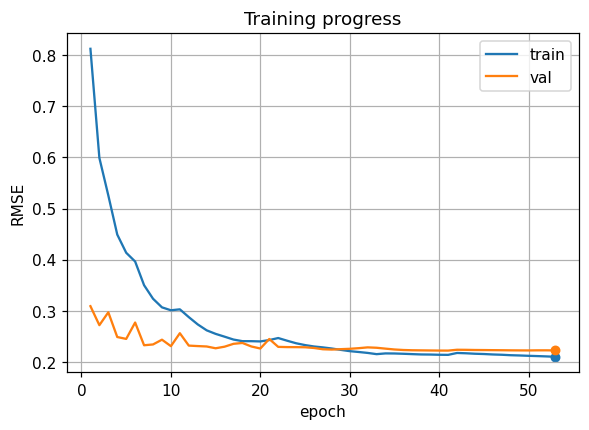

Epoch 001:   0%|                                                                              | 0/1984 [00:00<…

I0000 00:00:1750963115.096843    5982 cuda_dnn.cc:529] Loaded cuDNN version 91002


Epoch 001 • train=0.812090 • val=0.309239 • impr= 26.9% • lr=1.31e-04 • g≈6208.92


Epoch 002:   0%|                                                                              | 0/1984 [00:00<…

Epoch 002 • train=0.598902 • val=0.272110 • impr= 35.6% • lr=1.74e-04 • g≈3450.56


Epoch 003:   0%|                                                                              | 0/1984 [00:00<…

Epoch 003 • train=0.525628 • val=0.297252 • impr= 29.7% • lr=4.56e-04 • g≈1151.56


Epoch 004:   0%|                                                                              | 0/1984 [00:00<…

Epoch 004 • train=0.449128 • val=0.248953 • impr= 41.1% • lr=1.96e-04 • g≈2288.31


Epoch 005:   0%|                                                                              | 0/1984 [00:00<…

Epoch 005 • train=0.413580 • val=0.245274 • impr= 42.0% • lr=1.62e-05 • g≈25580.60


Epoch 006:   0%|                                                                              | 0/1984 [00:00<…

Epoch 006 • train=0.396486 • val=0.277266 • impr= 34.4% • lr=4.63e-04 • g≈856.32


Epoch 007:   0%|                                                                              | 0/1984 [00:00<…

Epoch 007 • train=0.350196 • val=0.232865 • impr= 44.9% • lr=3.52e-04 • g≈993.48


Epoch 008:   0%|                                                                              | 0/1984 [00:00<…

Epoch 008 • train=0.323756 • val=0.234430 • impr= 44.6% • lr=2.08e-04 • g≈1557.59


Epoch 009:   0%|                                                                              | 0/1984 [00:00<…

Epoch 009 • train=0.306936 • val=0.243749 • impr= 42.3% • lr=8.11e-05 • g≈3786.93


Epoch 010:   0%|                                                                              | 0/1984 [00:00<…

Epoch 010 • train=0.301226 • val=0.231132 • impr= 45.3% • lr=1.76e-05 • g≈17091.14


Epoch 011:   0%|                                                                              | 0/1984 [00:00<…

Epoch 011 • train=0.303060 • val=0.256403 • impr= 39.4% • lr=4.94e-04 • g≈614.01


Epoch 012:   0%|                                                                              | 0/1984 [00:00<…

Epoch 012 • train=0.287834 • val=0.232182 • impr= 45.1% • lr=4.66e-04 • g≈617.53


Epoch 013:   0%|                                                                              | 0/1984 [00:00<…

Epoch 013 • train=0.273594 • val=0.231263 • impr= 45.3% • lr=4.19e-04 • g≈652.24


Epoch 014:   0%|                                                                              | 0/1984 [00:00<…

Epoch 014 • train=0.262022 • val=0.230475 • impr= 45.5% • lr=3.58e-04 • g≈732.02


Epoch 015:   0%|                                                                              | 0/1984 [00:00<…

Epoch 015 • train=0.255113 • val=0.226959 • impr= 46.3% • lr=2.87e-04 • g≈888.32


Epoch 016:   0%|                                                                              | 0/1984 [00:00<…

Epoch 016 • train=0.249638 • val=0.230077 • impr= 45.6% • lr=2.14e-04 • g≈1168.18


Epoch 017:   0%|                                                                              | 0/1984 [00:00<…

Epoch 017 • train=0.244001 • val=0.235671 • impr= 44.3% • lr=1.44e-04 • g≈1691.66


Epoch 018:   0%|                                                                              | 0/1984 [00:00<…

Epoch 018 • train=0.240863 • val=0.237345 • impr= 43.9% • lr=8.52e-05 • g≈2827.47


Epoch 019:   0%|                                                                              | 0/1984 [00:00<…

Epoch 019 • train=0.240838 • val=0.230464 • impr= 45.5% • lr=4.20e-05 • g≈5737.80


Epoch 020:   0%|                                                                              | 0/1984 [00:00<…

Epoch 020 • train=0.240347 • val=0.226520 • impr= 46.4% • lr=1.86e-05 • g≈12942.62


Epoch 021:   0%|                                                                              | 0/1984 [00:00<…

Epoch 021 • train=0.243039 • val=0.245116 • impr= 42.0% • lr=4.99e-04 • g≈486.60


Epoch 022:   0%|                                                                              | 0/1984 [00:00<…

Epoch 022 • train=0.246986 • val=0.229706 • impr= 45.7% • lr=4.94e-04 • g≈499.73


Epoch 023:   0%|                                                                              | 0/1984 [00:00<…

Epoch 023 • train=0.241713 • val=0.229266 • impr= 45.8% • lr=4.84e-04 • g≈499.89


Epoch 024:   0%|                                                                              | 0/1984 [00:00<…

Epoch 024 • train=0.236780 • val=0.229184 • impr= 45.8% • lr=4.68e-04 • g≈506.36


Epoch 025:   0%|                                                                              | 0/1984 [00:00<…

Epoch 025 • train=0.233209 • val=0.228944 • impr= 45.8% • lr=4.47e-04 • g≈521.92


Epoch 026:   0%|                                                                              | 0/1984 [00:00<…

Epoch 026 • train=0.230474 • val=0.227527 • impr= 46.2% • lr=4.22e-04 • g≈546.57


Epoch 027:   0%|                                                                              | 0/1984 [00:00<…

Epoch 027 • train=0.228689 • val=0.225042 • impr= 46.8% • lr=3.93e-04 • g≈582.32


Epoch 028:   0%|                                                                              | 0/1984 [00:00<…

Epoch 028 • train=0.226489 • val=0.224441 • impr= 46.9% • lr=3.61e-04 • g≈628.01


Epoch 029:   0%|                                                                              | 0/1984 [00:00<…

Epoch 029 • train=0.223807 • val=0.225243 • impr= 46.7% • lr=3.26e-04 • g≈686.14


Epoch 030:   0%|                                                                              | 0/1984 [00:00<…

Epoch 030 • train=0.221344 • val=0.225948 • impr= 46.6% • lr=2.90e-04 • g≈762.90


Epoch 031:   0%|                                                                              | 0/1984 [00:00<…

Epoch 031 • train=0.219698 • val=0.227163 • impr= 46.3% • lr=2.53e-04 • g≈867.23


Epoch 032:   0%|                                                                              | 0/1984 [00:00<…

Epoch 032 • train=0.217898 • val=0.228726 • impr= 45.9% • lr=2.17e-04 • g≈1005.86


Epoch 033:   0%|                                                                              | 0/1984 [00:00<…

Epoch 033 • train=0.215496 • val=0.227975 • impr= 46.1% • lr=1.81e-04 • g≈1191.46


Epoch 034:   0%|                                                                              | 0/1984 [00:00<…

Epoch 034 • train=0.216938 • val=0.226250 • impr= 46.5% • lr=1.47e-04 • g≈1477.00


Epoch 035:   0%|                                                                              | 0/1984 [00:00<…

Epoch 035 • train=0.216778 • val=0.224601 • impr= 46.9% • lr=1.15e-04 • g≈1877.77


Epoch 036:   0%|                                                                              | 0/1984 [00:00<…

Epoch 036 • train=0.216219 • val=0.223593 • impr= 47.1% • lr=8.73e-05 • g≈2476.91


Epoch 037:   0%|                                                                              | 0/1984 [00:00<…

Epoch 037 • train=0.215530 • val=0.223092 • impr= 47.2% • lr=6.31e-05 • g≈3416.91


Epoch 038:   0%|                                                                              | 0/1984 [00:00<…

Epoch 038 • train=0.214893 • val=0.222887 • impr= 47.3% • lr=4.34e-05 • g≈4956.70


Epoch 039:   0%|                                                                              | 0/1984 [00:00<…

Epoch 039 • train=0.214712 • val=0.222680 • impr= 47.3% • lr=2.86e-05 • g≈7512.62


Epoch 040:   0%|                                                                              | 0/1984 [00:00<…

Epoch 040 • train=0.214274 • val=0.222503 • impr= 47.4% • lr=1.91e-05 • g≈11220.36


Epoch 041:   0%|                                                                              | 0/1984 [00:00<…

Epoch 041 • train=0.214107 • val=0.222439 • impr= 47.4% • lr=1.51e-05 • g≈14157.29


Epoch 042:   0%|                                                                              | 0/1984 [00:00<…

Epoch 042 • train=0.217813 • val=0.224082 • impr= 47.0% • lr=5.00e-04 • g≈436.01


Epoch 043:   0%|                                                                              | 0/1984 [00:00<…

Epoch 043 • train=0.217200 • val=0.223928 • impr= 47.0% • lr=4.98e-04 • g≈436.36


Epoch 044:   0%|                                                                              | 0/1984 [00:00<…

Epoch 044 • train=0.216290 • val=0.223609 • impr= 47.1% • lr=4.95e-04 • g≈437.34


Epoch 045:   0%|                                                                              | 0/1984 [00:00<…

Epoch 045 • train=0.215740 • val=0.223474 • impr= 47.1% • lr=4.90e-04 • g≈440.30


Epoch 046:   0%|                                                                              | 0/1984 [00:00<…

Epoch 046 • train=0.214863 • val=0.223296 • impr= 47.2% • lr=4.84e-04 • g≈443.87


Epoch 047:   0%|                                                                              | 0/1984 [00:00<…

Epoch 047 • train=0.214308 • val=0.223152 • impr= 47.2% • lr=4.77e-04 • g≈449.43


Epoch 048:   0%|                                                                              | 0/1984 [00:00<…

Epoch 048 • train=0.213414 • val=0.222950 • impr= 47.3% • lr=4.68e-04 • g≈455.67


Epoch 049:   0%|                                                                              | 0/1984 [00:00<…

Epoch 049 • train=0.212904 • val=0.222820 • impr= 47.3% • lr=4.59e-04 • g≈464.21


Epoch 050:   0%|                                                                              | 0/1984 [00:00<…

Epoch 050 • train=0.212244 • val=0.222750 • impr= 47.3% • lr=4.48e-04 • g≈474.02


Epoch 051:   0%|                                                                              | 0/1984 [00:00<…

Epoch 051 • train=0.211687 • val=0.222959 • impr= 47.3% • lr=4.36e-04 • g≈485.77


Epoch 052:   0%|                                                                              | 0/1984 [00:00<…

Epoch 052 • train=0.211071 • val=0.222977 • impr= 47.3% • lr=4.23e-04 • g≈499.26


Epoch 053:   0%|                                                                              | 0/1984 [00:00<…

Epoch 053 • train=0.210326 • val=0.222704 • impr= 47.3% • lr=4.09e-04 • g≈514.50
Early stopping triggered.

Champion validation RMSE = 0.222439
Improvement vs baseline   =  47.4 %


In [19]:

# ─────────────────────────────────────────────────────────────────────────────
#  ONE-OFF  :  baseline on the untouched validation split
# ─────────────────────────────────────────────────────────────────────────────
def naive_rmse(ds_val):
    """RMSE when the forecast is always zero."""
    mse, n = 0.0, 0
    for _, y_day, _ in ds_val:
        y = y_day.numpy().squeeze()
        mse += np.sum(y ** 2)
        n   += y.size
    return math.sqrt(mse / n)

baseline_val_rmse = naive_rmse(ds_val_unbatched)
print(f"Baseline (predict-zero) RMSE on validation = {baseline_val_rmse:.6f}")

# ─────────────────────────────────────────────────────────────────────────────
#  Training loop (outer bar only → maximum throughput)                     #
# ─────────────────────────────────────────────────────────────────────────────
n_train_days = len(np.unique(day_id_tr))
print(f"Training sees {n_train_days} calendar days per epoch\n")

best_val_rmse = custom_stateful_training_loop(
        model_train         = model_train,
        model_val           = model_val,
        ds_train_batched    = ds_train_batched,
        ds_val              = ds_val_unbatched,
        n_train_days        = n_train_days,
        max_epochs          = MAX_EPOCHS,
        early_stop_patience = EARLY_STOP_PATIENCE,
        baseline_val_rmse   = baseline_val_rmse,
        weights_path        = weights_path)

print(f"\nChampion validation RMSE = {best_val_rmse:.6f}")
print(f"Improvement vs baseline   = {(1 - best_val_rmse/baseline_val_rmse)*100:5.1f} %")

